# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Our company wants to determine the "correct" salary for new job postings based on our existing job postings.  It is envisoned that this will take the guesswork out of the exisint process, and help to standardize salaries across departments.
In this effort, I will examine the job postings with salaries and then predict salaries for a new set of job postings.  As part of this effort, I will also determine which features in the data have the greatest impact on the salary of the position.

In [2]:
#import your libraries
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as py
import seaborn as sn
%matplotlib inline
#etc

#your info here
__author__ = "John Freeman"
__email__ = "dennis.freeman@southbridge.consulting"

In [3]:
def plot_feature(df, col, target, target_name, graph_num):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    #plt.figure(figsize = (14, 6))
    #plt.subplot(1, 2, graph_num)
    plt.subplot(3, 4, graph_num)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)[target].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    #plt.subplot(1, 2, graph_num + 1)
    plt.subplot(3, 4, graph_num + 1)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)[target].mean()
        std = df.groupby(col)[target].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sn.boxplot(x = col, y = target, data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel(target_name)
    #plt.show()

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [4]:
#load the data into a Pandas dataframe
train_features_df = pd.read_csv('data/train_features.csv')
train_salaries_df = pd.read_csv('data/train_salaries.csv')
test_features_df = pd.read_csv('data/test_features.csv')

### ---- 3 Clean the data ----

In [5]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
#we see that there are column headers in the files, and that the file formats match between 
#train and test features
train_features_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68


In [6]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
train_salaries_df.head(10)

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163
5,JOB1362684407692,113
6,JOB1362684407693,178
7,JOB1362684407694,73
8,JOB1362684407695,31
9,JOB1362684407696,104


In [7]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
test_features_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


In [8]:
#Using info to check the data types of each column
#It appears that the datatypes are appropriate with object for strings and int for numeric features
train_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [9]:
train_salaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


In [10]:
test_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [11]:
#Check if there are any duplicates in the supplied data sets
#This can lead to skewing the results during training
train_features_df.duplicated().sum()

0

In [12]:
train_salaries_df.duplicated().sum()

0

In [13]:
test_features_df.duplicated().sum()

0

In [14]:
#Are there any missing values in the data set; if so, will show as true
train_features_df.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [15]:
#Are there any missing values in the data set
train_salaries_df.isnull().any()

jobId     False
salary    False
dtype: bool

In [16]:
#Are there any missing values in the data set
test_features_df.isnull().any()

jobId                  False
companyId              False
jobType                False
degree                 False
major                  False
industry               False
yearsExperience        False
milesFromMetropolis    False
dtype: bool

In [17]:
#Identify category columns in dataset
train_features_df.columns

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [18]:
#create lists of category and numeric columns
category_columns = ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry']
numeric_columns = ['yearsExperience', 'milesFromMetropolis']

In [19]:
#Check the non jobId and companyId category to see if values are there and resonable
for cat in category_columns[2:]:
    print(train_features_df[cat].value_counts())

SENIOR            125886
VICE_PRESIDENT    125235
MANAGER           125121
CTO               125046
JANITOR           124971
CEO               124778
JUNIOR            124594
CFO               124369
Name: jobType, dtype: int64
HIGH_SCHOOL    236976
NONE           236854
BACHELORS      175495
DOCTORAL       175364
MASTERS        175311
Name: degree, dtype: int64
NONE           532355
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58596
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57801
Name: major, dtype: int64
WEB          143206
AUTO         142943
FINANCE      142867
EDUCATION    142819
OIL          142771
HEALTH       142755
SERVICE      142639
Name: industry, dtype: int64


In [20]:
#Summarize categorical and numeric features
train_features_df.describe(include = [py.number])

,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [21]:
#Summarize categorical and numeric features
train_features_df.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684909808,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


In [22]:
#Merge features and targets into single dataframe; not completely necessary, but helps later
train_df = pd.merge(train_features_df, train_salaries_df, on='jobId')

In [23]:
#Drop original dataframes
del train_features_df
del train_salaries_df

In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [25]:
train_df.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


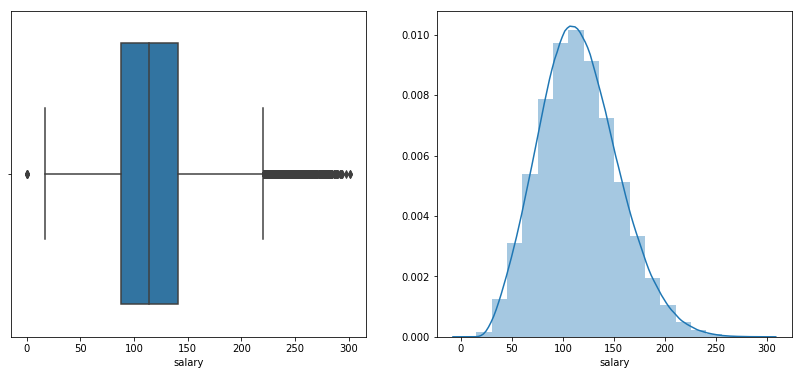

In [26]:
#Visualize target variable - salary - are there obvious patterns that need to be considered
plt.figure(figsize = (14,6))
plt.subplot(1,2,1)
sn.boxplot(train_df.salary)
plt.subplot(1,2,2)
sn.distplot(train_df.salary, bins=20)
plt.show()

In [27]:
#Using IQR rule to identify potential outliers - use Interquartile Range rule
#this is used to find outliers
stat = train_df.salary.describe()
print(stat)
IQR = stat['75%'] - stat['25%']
upper = stat['75%'] + 1.5 * IQR
lower = stat['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper,lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [28]:
#Examine potential outliers - check below lower bounds
train_df[train_df.salary < 8.5]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [29]:
#Since the jobType shown is not a non-paid position, then it can be assumed that this is
#corrupted or missing data, so these rows are dropped below
train_df = train_df[train_df.salary >= 8.5]

In [30]:
#Examine potential outliers - check above upper bounds
train_df.loc[train_df.salary > 220.5, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

Since most of the jobTypes shown above are Executive level, which can be very well paid
due to the value they bring to the company, and the Junior level are in well-paying industries,
I determined that these are legitimate entries, so they will not be removed.

<function matplotlib.pyplot.show(*args, **kw)>

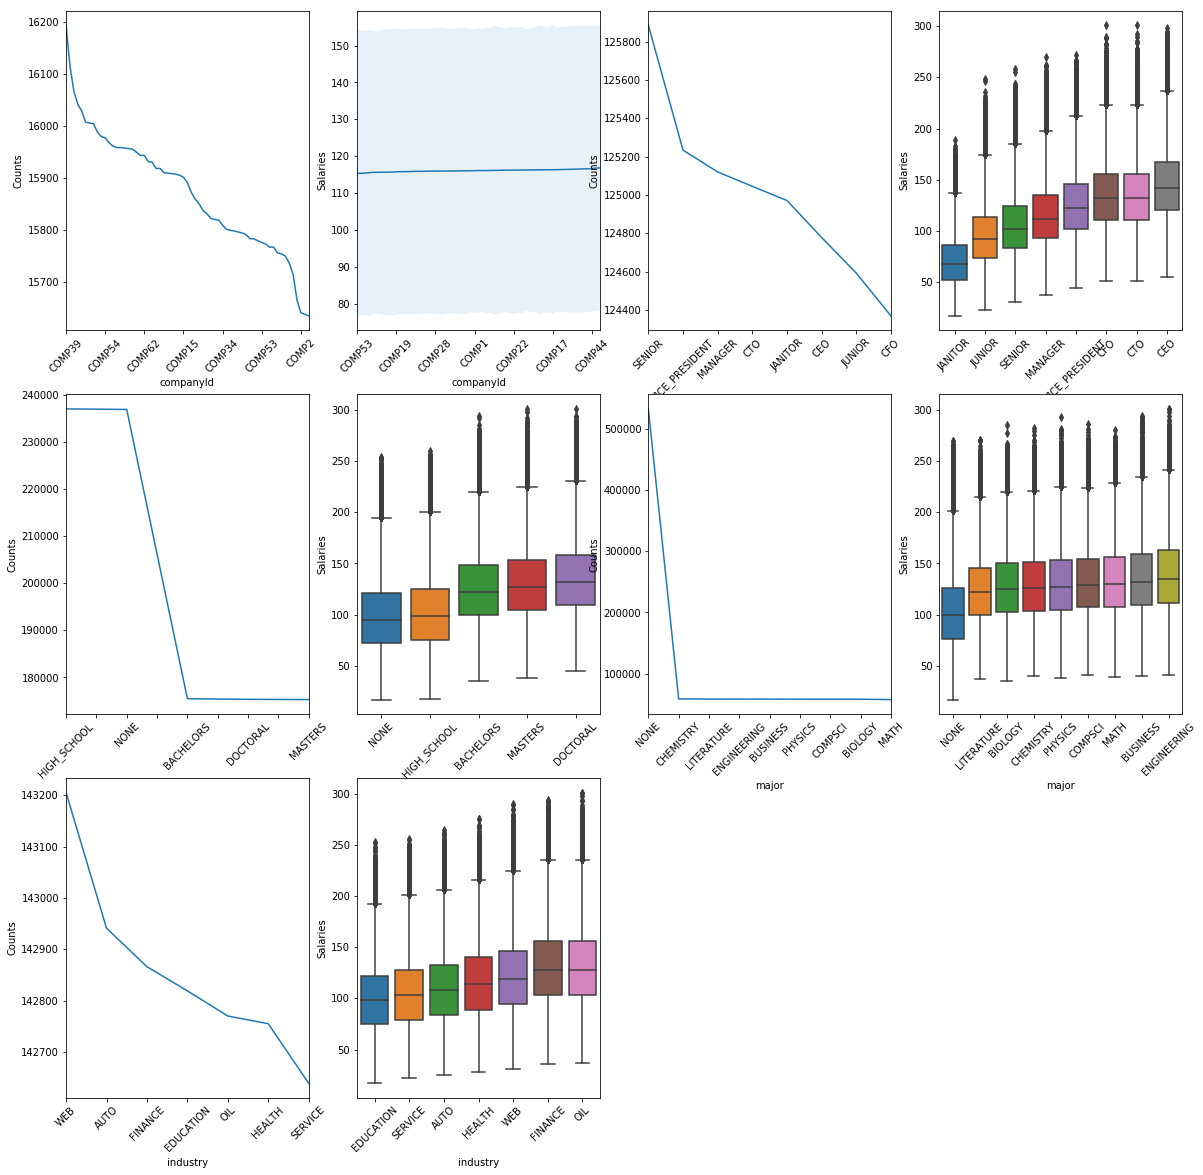

In [32]:
plt.subplots(figsize=(20, 20))
i = 1
for cat in category_columns[1:]:
    plot_feature(train_df, cat,'salary',"Salaries",i)
    i += 2
plt.show

### ---- 4 Explore the data (EDA) ----

In [3]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

### ---- 5 Establish a baseline ----

In [5]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [15]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [1]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data